# Introduction to JPEG Compression: Practical tools

**Author:** Martin Beneš

## Notebook setup

In [1]:
!pip install pillow numpy matplotlib requests  # install dependencies

In [2]:
# download 00001.tif from ALASKA website
import requests
res = requests.get('http://alaska.utt.fr/DATASETS/ALASKA_v2_TIFF_512_COLOR/00001.tif', verify=False)
with open('00001.tif', 'wb') as f:
    f.write(res.content)

/opt/miniconda3/envs/dev/lib/python3.8/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'alaska.utt.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


## PNG is lossless

First we load the image that will be used in this exercise using Python imaging library `PIL`.

The PIL object representing the image is converted to a `numpy` array of pixels.

In [3]:
import numpy as np
from PIL import Image
im = Image.open('00001.tif')  # load image as PIL object
RGB = np.array(im)  # convert to numpy

We can look at the shape of the image. The image consists of $512 \times 512$ pixels, each of which has has $3$ color values (R, G, B).

In [4]:
RGB.shape

(512, 512, 3)

We look at the image by using package `matplotlib`.

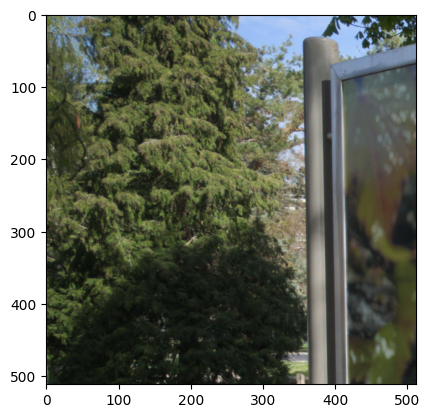

In [5]:
import matplotlib.pyplot as plt
plt.imshow(RGB);

To demostrate that PNG compression is lossless, we compress and decompress the image.

In [6]:
# compress PNG
im_out = Image.fromarray(RGB)  # convert numpy back to PIL object
im_out.save('output.png')  # compress image to PNG

# decompress PNG
im_in = Image.open('output.png')  # decompress PNG and load as PIL object
rgb_png = np.array(im_in)  # convert PIL object to numpy array

Lossless compression does not change the image data. For PNG, the original and the recompressed image are the same.

In [7]:
(RGB == rgb_png).all()  # the image is identical, compression did not change it

True

## JPEG is lossy

Let us do the same with JPEG compression, i.e., compress and decompress the image.

In [8]:
# compress JPEG
im_out = Image.fromarray(RGB)  # convert numpy to PIL object
im_out.save('output.jpeg')  # save PIL object as JPEG

# decompress JPEG
im_in = Image.open('output.jpeg')  # load JPEG as PIL object
rgb_jpeg = np.array(im_in)  # convert PIL object to numpy

The JPEG-compressed image differs from the original. JPEG compression changes the image.

In [9]:
(RGB == rgb_jpeg).all()  # images differ

False

We can compute the difference image (the difference between the images) and visualize to see the magnitude of changes.

For context, steganography usually makes changes $\pm1$.

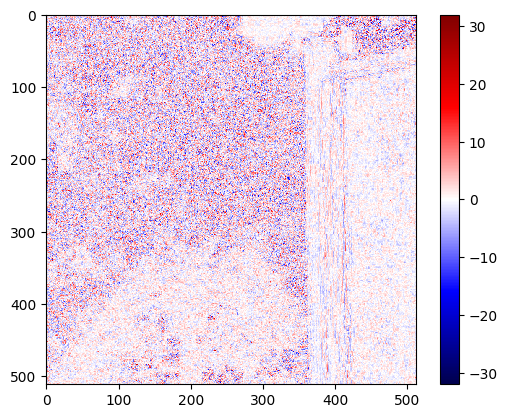

In [10]:
diff_G = RGB[:, :, 1] - rgb_jpeg[:, :, 1].astype('int')  # difference image of green channels

# Ensure that the colorbar is centered at 0
vmax = np.max(np.abs(diff_G))

plt.imshow(diff_G, cmap='seismic', interpolation='nearest', vmin=-vmax, vmax=vmax)  # plot heatmap
plt.colorbar();  # add colorbar on side

## Trading off file size and image quality via the quality factor (QF)

The primary goal of JPEG compression is to reduce the file size while maintaining high image quality. The most influential parameter of JPEG compression is the quality factor (QF). Many popular JPEG implementations use quality factors between $0$ and $100$.

To have fine-grained control over JPEG compression parameters, we will use the Python package `jpeglib`.

In [11]:
!pip install jpeglib

Same as before, we recompress the original image using JPEG compression. Only this time, we specify the QF by setting the `qt` parameter of the `write_spatial` method.

In [12]:
import jpeglib

# compress JPEG (with QF100)
im_out = jpeglib.from_spatial(RGB)  # convert numpy to jpeglib object
im_out.write_spatial('output_QF100.jpeg', qt=100)  # save jpeglib object as JPEG

# decompress JPEG
im_in = jpeglib.read_spatial('output_QF100.jpeg')  # load JPEG as jpeglib object
rgb_jpeg_qf100 = im_in.spatial  # convert jpeglib object to numpy

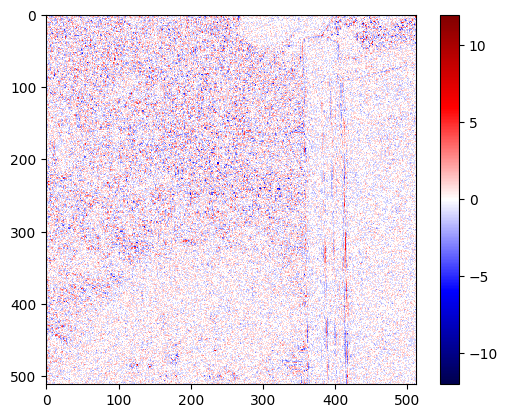

In [13]:
diff_G = RGB[:, :, 1] - rgb_jpeg_qf100[:, :, 1].astype('int')

vmax = np.max(np.abs(diff_G))  # 0-centered colorbar
plt.imshow(diff_G, cmap='seismic', interpolation='nearest', vmin=-vmax, vmax=vmax)  # plot heatmap
plt.colorbar();  # add colorbar on side

## Hands-on: Visual analysis

- What visual artifacts does JPEG compression leave? (hint: zoom in)
- What impact does the quality factor have?

### Solution

The artifacts of JPEG are visible if you zoom in.

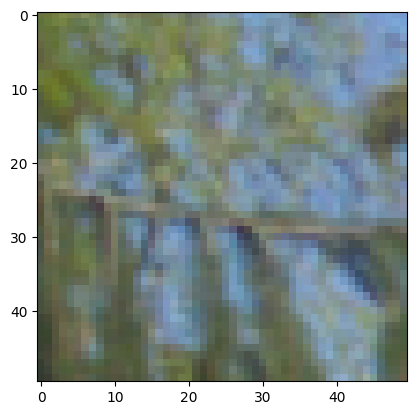

In [14]:
plt.imshow(RGB[:50, :50]);

For QF75, we might notice some block structure. The reason is that JPEG compression splits the image into non-overlapping $8 \times 8$ blocks.

In [15]:
# recompress JPEG (with QF75)
jpeglib.from_spatial(RGB).write_spatial('output_jpeg_qf75.jpeg', qt=75)
rgb_jpeg_qf75 = jpeglib.read_spatial('output_jpeg_qf75.jpeg').spatial

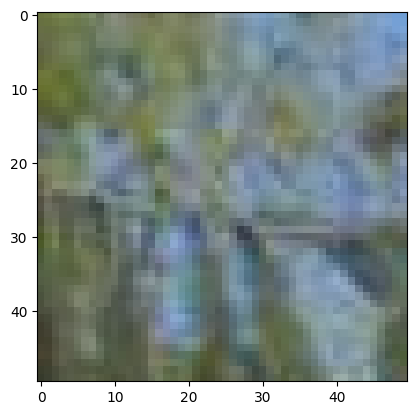

In [16]:
plt.imshow(rgb_jpeg_qf75[:50, :50]);

With QF25, the block structure becomes very visible.

As JPEG removes high frequencies, we can see that content of each individual block is becoming flat, while continuity between adjacent blocks is destroyed by stronger compression.

In [17]:
# recompress JPEG (with QF25)
jpeglib.from_spatial(RGB).write_spatial('output_jpeg_qf25.jpeg', qt=25)
rgb_jpeg_qf25 = jpeglib.read_spatial('output_jpeg_qf25.jpeg').spatial

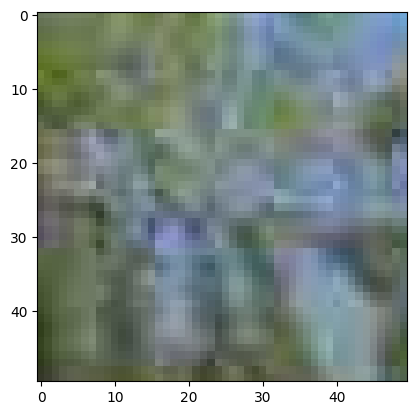

In [18]:
plt.imshow(rgb_jpeg_qf25[:50, :50]);